In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS
from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
import random
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from wordcloud import WordCloud
from nltk.util import ngrams
import ast
from textblob import TextBlob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
pio.renderers.default = "notebook"


# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

In [2]:
# Carregando os diferentes arquivos CSV
links_small = pd.read_csv('the-movies-dataset/links_small.csv')
movies_metadata = pd.read_csv('the-movies-dataset/movies_metadata.csv')

/var/folders/2r/p7xt963j61jdwt54k047z_kh0000gn/T/ipykernel_37053/3125572303.py:3: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
# Removendo linhas onde a coluna 'title' possui valores nulos, pois o título é uma informação essencial
movies_metadata = movies_metadata.dropna(subset=['title'])

# Criando uma nova coluna 'year', que contém apenas o ano extraído da coluna 'release_date'
movies_metadata['year'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if pd.notnull(x) else np.nan
)

# Convertendo a coluna 'year' para valores numéricos, substituindo valores inválidos (não numéricos) por NaN
movies_metadata['year'] = pd.to_numeric(movies_metadata['year'], errors='coerce')
movies_metadata = movies_metadata.dropna(subset=['year'])

# Extraindo a decada do filme
movies_metadata['decade'] = (movies_metadata['year'] // 10) * 10

# Removendo possíveis linhas duplicadas, se houver mais de uma linha com o mesmo 'id' (coluna identificadora do filme)
movies_metadata = movies_metadata.drop_duplicates(subset='id', keep='first')

# Convertendo a coluna 'budget' e 'revenue' para valores numéricos, substituindo valores inválidos (não numéricos) por NaN
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')

# No dataset links_small, filtramos para manter apenas as linhas onde a coluna 'tmdbId' não tem valores nulos e convertemos para inteiros
links_small_id = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# Exibindo a estrutura do dataset movies_metadata e links_small após a limpeza
print("\nEstrutura de Movies Metadata após a limpeza:")
print(movies_metadata.info())

print("\nEstrutura de Links Small após a limpeza:")
print(links_small.info())


Estrutura de Movies Metadata após a limpeza:
<class 'pandas.core.frame.DataFrame'>
Index: 45346 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45346 non-null  object 
 1   belongs_to_collection  4485 non-null   object 
 2   budget                 45346 non-null  int64  
 3   genres                 45346 non-null  object 
 4   homepage               7761 non-null   object 
 5   id                     45346 non-null  object 
 6   imdb_id                45332 non-null  object 
 7   original_language      45335 non-null  object 
 8   original_title         45346 non-null  object 
 9   overview               44405 non-null  object 
 10  popularity             45346 non-null  object 
 11  poster_path            45007 non-null  object 
 12  production_companies   45346 non-null  object 
 13  production_countries   45346 non-null  object 
 14  release_date 

In [4]:
#Removendo linhas com valores nulos e criando uma nova coluna 'ROI' que representa a relação entre a receita e o orçamento
movies_metadata['revenue'] = movies_metadata['revenue'].replace(0, np.nan)
movies_metadata['budget'] = movies_metadata['budget'].replace(0, np.nan)
movies_metadata['ROI'] = movies_metadata['revenue'] / movies_metadata['budget'] - 1
movies_metadata['profit'] = movies_metadata['revenue'] - movies_metadata['budget']

In [5]:
#Filtrando os filmes que tem relação com link_small
movies_metadata['id'] = movies_metadata['id'].astype('int')
movies_metadata = movies_metadata[movies_metadata['id'].isin(links_small_id)]

In [6]:
movies_metadata = pd.merge(movies_metadata, links_small, left_on='id', right_on='tmdbId', how='inner')

In [7]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9082 entries, 0 to 9081
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9082 non-null   object 
 1   belongs_to_collection  1672 non-null   object 
 2   budget                 4639 non-null   float64
 3   genres                 9082 non-null   object 
 4   homepage               1971 non-null   object 
 5   id                     9082 non-null   int64  
 6   imdb_id                9082 non-null   object 
 7   original_language      9082 non-null   object 
 8   original_title         9082 non-null   object 
 9   overview               9070 non-null   object 
 10  popularity             9082 non-null   object 
 11  poster_path            9079 non-null   object 
 12  production_companies   9082 non-null   object 
 13  production_countries   9082 non-null   object 
 14  release_date           9082 non-null   object 
 15  reve

In [8]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995.0,1990.0,11.451801,343554033.0,1,114709,862.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995.0,1990.0,NaN,NaN,3,113228,15602.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995.0,1990.0,NaN,NaN,5,113041,11862.0


In [9]:
ratings = pd.read_csv('./the-movies-dataset/ratings_small.csv')

In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [12]:
# Counting the number of occurrences of each user
user_counts = ratings['userId'].value_counts()

# Selecting users who appear the most until the dataset has at most 1000 rows
selected_users = []
total_rows = 0

for user, count in user_counts.items():
    if count > 700:
        continue
    if total_rows + count > 10000:
        break
    selected_users.append(user)
    total_rows += count

# Filtering the dataset to only include the selected users
ratings = ratings[ratings['userId'].isin(selected_users)]

In [13]:
# Garantir que movieId seja do mesmo tipo em ambas as tabelas
ratings['movieId'] = ratings['movieId'].astype(int)
movies_metadata['movieId'] = movies_metadata['movieId'].astype(int)

# Mesclar as tabelas
data = pd.merge(ratings, movies_metadata, on='movieId', how='left')
print(data.shape)

(9667, 34)


In [14]:
import pandas as pd
pd.set_option('display.max_columns', None)


In [15]:
data.head()

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,imdbId,tmdbId
0,48,1,4.0,1318796720,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995.0,1990.0,11.451801,343554033.0,114709.0,862.0
1,48,2,3.5,1322169967,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,113497.0,8844.0
2,48,34,3.0,1322169717,False,"{'id': 9435, 'name': 'Babe Collection', 'poste...",30000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,9598.0,tt0112431,en,Babe,Babe is a little pig who doesn't quite know hi...,14.404764,/gN6X3fwPya8pLffk9OEWV3DqBnE.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",1995-07-18,254134910.0,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A little pig goes a long way.,Babe,False,6.0,756.0,1995.0,1990.0,7.471164,224134910.0,112431.0,9598.0
3,48,110,4.0,1319746142,False,NaN,72000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,197.0,tt0112573,en,Braveheart,"Enraged at the slaughter of Murron, his new br...",20.755149,/2qAgGeYdLjelOEqjW9FYvPHpplC.jpg,"[{'name': 'Icon Entertainment International', ...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-05-24,210000000.0,177.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Every man dies. Not every man truly lives.,Braveheart,False,7.7,3404.0,1995.0,1990.0,1.916667,138000000.0,112573.0,197.0
4,48,111,3.0,1439687078,False,NaN,1300000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,103.0,tt0075314,en,Taxi Driver,A mentally unstable Vietnam War veteran works ...,14.092713,/yxq4pk1xGmro8tQABuQIrWrvdaE.jpg,"[{'name': 'Columbia Pictures Corporation', 'id...","[{'iso_3166_1': 'US', 'name': 'United States o...",1976-02-07,28262574.0,114.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"On every street in every city, there's a nobod...",Taxi Driver,False,8.1,2632.0,1976.0,1970.0,20.740442,26962574.0,75314.0,103.0


In [16]:
# Preencher 'budget' e 'revenue' com a mediana
data['budget'] = data['budget'].fillna(data['budget'].median())
data['revenue'] = data['revenue'].fillna(data['revenue'].median())

# Preencher 'runtime' com a mediana
data['runtime'] = data['runtime'].fillna(data['runtime'].median())

# Preencher 'vote_average' e 'vote_count' com a mediana
data['vote_average'] = data['vote_average'].fillna(data['vote_average'].median())
data['vote_count'] = data['vote_count'].fillna(data['vote_count'].median())

# Preencher 'year' e 'decade' com a mediana
data['year'] = data['year'].fillna(data['year'].median())
data['decade'] = data['decade'].fillna(data['decade'].median())

# Preencher 'imdbId' e 'tmdbId' com zero (assumindo que zero indica ausência)
data['imdbId'] = data['imdbId'].fillna(0)
data['tmdbId'] = data['tmdbId'].fillna(0)

# 'ROI' e 'profit' possuem muitos nulos. Podemos preenchê-los com zero ou deixar como estão, dependendo da importância.
data['ROI'] = data['ROI'].fillna(0)
data['profit'] = data['profit'].fillna(0)

In [17]:
# Preencher 'adult' com False
data['adult'] = data['adult'].fillna(False)

# Preencher colunas categóricas com 'Unknown' ou 'No'
categorical_fill = {
    'original_language': 'Unknown',
    'status': 'Unknown',
    'video': False,  # Assumindo que a ausência indica False
    'homepage': 'Unknown',
    'poster_path': 'Unknown',
}
data.fillna(value=categorical_fill, inplace=True)

# Preencher 'tagline' com string vazia
data['tagline'] = data['tagline'].fillna('')

/var/folders/2r/p7xt963j61jdwt54k047z_kh0000gn/T/ipykernel_37053/2411504032.py:12: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [18]:
import ast

# Função para extrair nomes de uma coluna que contém listas de dicionários
def extract_names(list_str, key='name'):
    try:
        items = ast.literal_eval(list_str)
        return [item[key] for item in items]
    except (ValueError, SyntaxError):
        return []

# Extrair gêneros
data['genres_list'] = data['genres'].apply(lambda x: extract_names(x, 'name'))

# Extrair nomes das companhias de produção
data['production_companies_list'] = data['production_companies'].apply(lambda x: extract_names(x, 'name'))

# Extrair nomes dos países de produção
data['production_countries_list'] = data['production_countries'].apply(lambda x: extract_names(x, 'name'))

# Extrair nomes das línguas faladas
data['spoken_languages_list'] = data['spoken_languages'].apply(lambda x: extract_names(x, 'name'))

In [19]:
# Identificar os gêneros mais frequentes
all_genres = data['genres_list'].explode()
top_genres = all_genres.value_counts().index[:20]  # Selecionar top 20 gêneros

# Criar colunas binárias para os top gêneros
for genre in top_genres:
    data[f'genre_{genre}'] = data['genres_list'].apply(lambda x: 1 if genre in x else 0)

In [20]:
# Contar o número de companhias de produção
data['num_production_companies'] = data['production_companies_list'].apply(len)

In [21]:
# Contar o número de países de produção
data['num_production_countries'] = data['production_countries_list'].apply(len)

In [22]:
# Contar o número de línguas faladas
data['num_spoken_languages'] = data['spoken_languages_list'].apply(len)

In [23]:
# Converter 'release_date' para datetime, se ainda não estiver
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Extrair ano de lançamento a partir de 'release_date'
data['release_year'] = data['release_date'].dt.year
data['release_year'] = data['release_year'].fillna(data['release_year'].median())

In [24]:
from sklearn.preprocessing import LabelEncoder

# Codificar 'original_language' usando Label Encoding
le_language = LabelEncoder()
data['original_language_encoded'] = le_language.fit_transform(data['original_language'])


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preencher 'overview' com string vazia se ainda não estiver feito
data['overview'] = data['overview'].fillna('')

# Limitar o número de features para evitar alta dimensionalidade
tfidf = TfidfVectorizer(max_features=100)
overview_tfidf = tfidf.fit_transform(data['overview']).toarray()

# Criar um DataFrame com os features TF-IDF
tfidf_df = pd.DataFrame(overview_tfidf, columns=[f'overview_tfidf_{i}' for i in range(overview_tfidf.shape[1])])

# Concatenar com o DataFrame principal
data = pd.concat([data, tfidf_df], axis=1)

In [26]:
# Codificar 'userId' e 'movieId' usando Label Encoding
le_user = LabelEncoder()
le_movie = LabelEncoder()

data['user_encoded'] = le_user.fit_transform(data['userId'])
data['movie_encoded'] = le_movie.fit_transform(data['movieId'])

In [27]:
# Média de avaliações e contagem por usuário
user_stats = data.groupby('user_encoded')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'user_mean_rating', 'count': 'user_rating_count'})
data = data.merge(user_stats, on='user_encoded', how='left')

# Média de avaliações e contagem por filme
movie_stats = data.groupby('movie_encoded')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'movie_mean_rating', 'count': 'movie_rating_count'})
data = data.merge(movie_stats, on='movie_encoded', how='left')
data["production_company_first"] = data["production_companies_list"].apply(lambda x: x[0] if x else "Indie")


In [28]:
# Seleção de colunas
selected_columns = [
    'user_encoded',
    'movie_encoded',
    'revenue',
    'runtime',
    'vote_average',
    'vote_count',
    'year',
    'decade',
    'ROI',    
    'original_language_encoded',
    'release_year',
    'num_production_companies',
    'num_production_countries',
    'num_spoken_languages',
    'user_mean_rating',
    'user_rating_count',
    'movie_mean_rating',
    'movie_rating_count'
] 

# + [f'genre_{genre}' for genre in top_genres]

# selected_columns += list(tfidf_df.columns)

# Verificar as colunas selecionadas
print("Colunas selecionadas para o modelo:")
print(selected_columns)

Colunas selecionadas para o modelo:
['user_encoded', 'movie_encoded', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'original_language_encoded', 'release_year', 'num_production_companies', 'num_production_countries', 'num_spoken_languages', 'user_mean_rating', 'user_rating_count', 'movie_mean_rating', 'movie_rating_count']


In [29]:
features = selected_columns

In [30]:

X = data[selected_columns]
y = data['rating']



In [31]:
# Verificar se 'features' está definido
print("Features selecionadas:")
print(features)

# Verificar as formas de X e y
print("\nForma de X:", X.shape)
print("Forma de y:", y.shape)

Features selecionadas:
['user_encoded', 'movie_encoded', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'original_language_encoded', 'release_year', 'num_production_companies', 'num_production_countries', 'num_spoken_languages', 'user_mean_rating', 'user_rating_count', 'movie_mean_rating', 'movie_rating_count']

Forma de X: (9667, 18)
Forma de y: (9667,)


Features selecionadas:
['user_encoded', 'movie_encoded', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'decade', 'ROI', 'original_language_encoded', 'release_year', 'num_production_companies', 'num_production_countries', 'num_spoken_languages', 'user_mean_rating', 'user_rating_count', 'movie_mean_rating', 'movie_rating_count']
18

Forma de X: (9667, 18)
Forma de y: (9667,)

Classes únicas em y_classes: ['bom' 'médio' 'ruim']

Dados divididos:
Treino: (7733, 18), Teste: (1934, 18)

Distribuição das classes no treino:
bom      4400
médio    2749
ruim      584
Name: count, dtype: int64

Distribuição das classes no teste:
bom      1101
médio     687
ruim      146
Name: count, dtype: int64

Treinando modelo: AdaBoost


/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=37053) is multi-threaded, use of fork() may lead to deadlocks in the child.

/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=37053) is multi-threaded, use of fork() may lead to deadlocks in the child.

/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=37053) is multi-threaded, use of fork() may lead to deadlocks in the child.

/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=37053) is multi-threaded, use of fork() may lead to d


Resultados para AdaBoost:
Acurácia: 0.7477
F1-score: 0.7301
Recall: 0.7477

Matriz de Confusão:


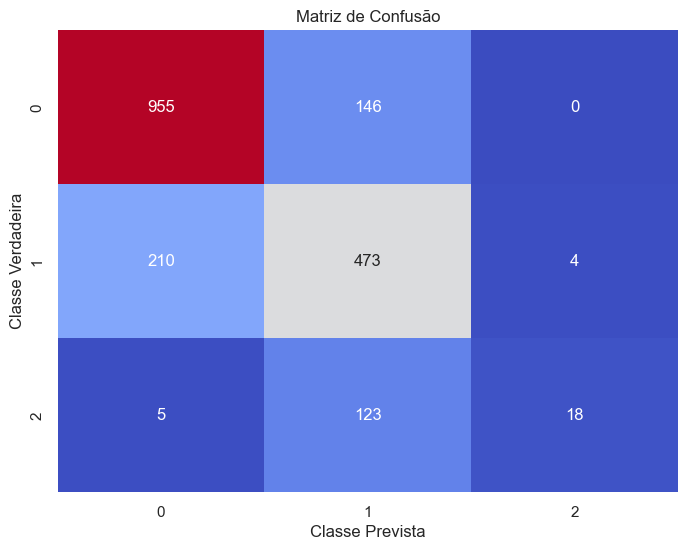


Treinando modelo: Logistic Regression


/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMA


Resultados para Logistic Regression:
Acurácia: 0.7746
F1-score: 0.7666
Recall: 0.7746

Matriz de Confusão:


/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning:

Rounding errors prevent the line search from converging

/Users/pedro-pc/Developer/INF1038---APRENDIZADO-AUTOMATICO/venv/lib/python3.12/site-packages/sklearn/utils/optimize.py:311: UserWarning:

Line Search failed



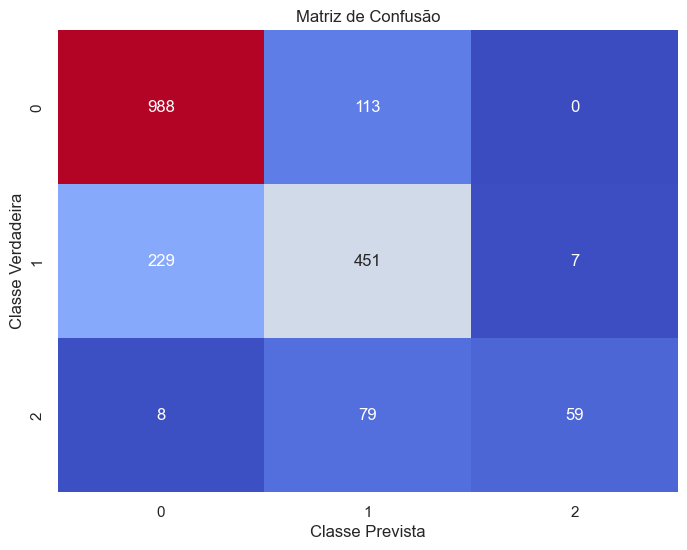


Treinando modelo: Decision Tree

Resultados para Decision Tree:
Acurácia: 0.7859
F1-score: 0.7812
Recall: 0.7859

Matriz de Confusão:


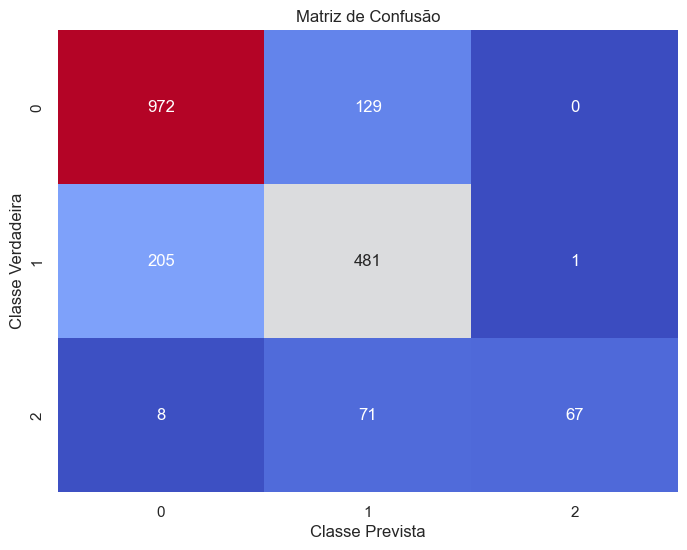


Treinando modelo: KNN

Resultados para KNN:
Acurácia: 0.5372
F1-score: 0.5162
Recall: 0.5372

Matriz de Confusão:


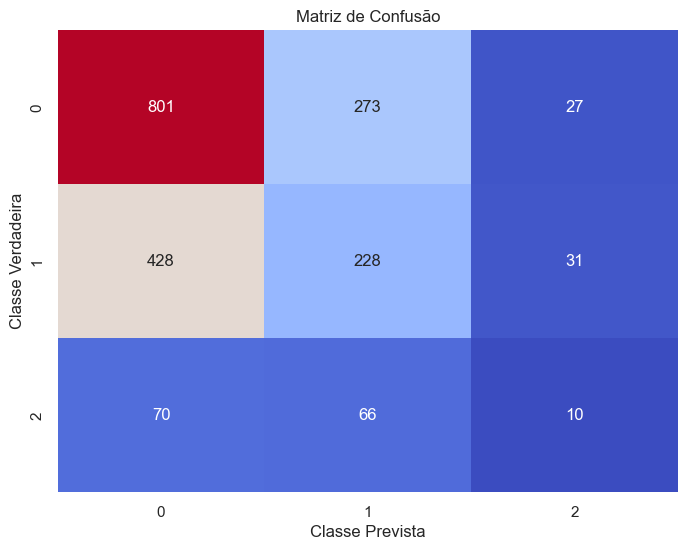


Treinando modelo: Random Forest


In [ ]:
# Supondo que 'X' e 'y' já estejam definidos
# X: matriz de características
# y: vetor de notas (valores numéricos entre 0.5 e 5)

# Verificar se 'features' está definido
print("Features selecionadas:")
print(features)
print(len(features))

# Verificar as formas de X e y
print("\nForma de X:", X.shape)
print("Forma de y:", y.shape)

# Converter y para categorias com base nos intervalos especificados
def categorize_rating(rating):
    if 0.5 <= rating < 2:
        return 'ruim'
    elif 2 <= rating < 3.5:
        return 'médio'
    elif 3.5 <= rating <= 5:
        return 'bom'
    else:
        return 'indefinido'   # Para garantir que todas as notas sejam categorizadas

# Aplicar a função de categorização
y_classes = np.array([categorize_rating(r) for r in y])

# Verificar as classes únicas
print("\nClasses únicas em y_classes:", np.unique(y_classes))

# Remover possíveis instâncias 'indefinido' se existirem
valid_indices = y_classes != 'indefinido'
X = X[valid_indices]
y_classes = y_classes[valid_indices]

# Divisão treino-teste (80% treino, 20% teste) com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y_classes, test_size=0.2, random_state=42, stratify=y_classes
)

print("\nDados divididos:")
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

# Verificar a distribuição das classes no treino e teste
train_class_counts = pd.Series(y_train).value_counts().sort_index()
test_class_counts = pd.Series(y_test).value_counts().sort_index()
print("\nDistribuição das classes no treino:")
print(train_class_counts)
print("\nDistribuição das classes no teste:")
print(test_class_counts)

# Definir o modelo base
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=100000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
# Definir o espaço de hiperparâmetros para a busca em grade
param_grids = {
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [1.0, 0.5, 0.1]
    },
    'Logistic Regression': {
        'penalty': ['l2'],
        'C': [0.0001, 0.1, 1, 10],
        'solver': ['newton-cg']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20, 30, 50],  # Mais profundidade
        'min_samples_split': [2, 5, 10, 15],    # Mais opções
        'min_samples_leaf': [1, 2, 4, 6, 8]     # Mais opções
    },
    'KNN': {
        'n_neighbors': [30,33,35],  # Mais vizinhos
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Diferentes algoritmos
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5]
    }
}
# Métricas de avaliação
metrics = {
    'accuracy': accuracy_score,
    'f1_score': f1_score,
    'recall': recall_score
}

# Resultados
results = []

# Testar cada modelo com busca de hiperparâmetros
for model_name, model in models.items():
    print(f"\nTreinando modelo: {model_name}")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=StratifiedKFold(n_splits=10),
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )


    # Rodar o GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Prever no conjunto de teste
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calcular as métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Exibir os resultados
    print(f"\nResultados para {model_name}:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nMatriz de Confusão:")
    plt.figure(figsize=(8, 6))

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Criar um heatmap da matriz de confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    
    # Adicionar títulos e rótulos
    plt.title('Matriz de Confusão')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Prevista')
    
    # Exibir o gráfico
    plt.show()
    
    # Armazenar os resultados
    results.append({
        'model': model_name,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall
    })

# Comparar os resultados de todos os modelos
results_df = pd.DataFrame(results)
print("\nComparação de Desempenho entre Modelos:")
print(results_df)


In [ ]:
# Encode target labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_classes)

# One-hot encode the target classes for neural network compatibility
y_categorical = to_categorical(y_encoded)

# Split data (already defined in your code)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Define a neural network model
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))  # Adding dropout for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Softmax for multi-class classification
    return model

# Initialize and compile the model
input_dim = X_train.shape[1]
nn_model = create_nn_model(input_dim)
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test data
y_pred_proba = nn_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_proba.argmax(axis=1))
y_true = label_encoder.inverse_transform(y_test.argmax(axis=1))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Print results
print(f"\nResultados para Neural Network:")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()